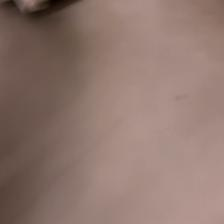

Steering: 1.0, Throttle: -0.7267764210700989
Sent final command with steering and throttle set to 0.
Resources released and program exited.


KeyboardInterrupt: 

In [12]:
print("Importing packages...")
import cv2
import numpy as np
import torch
from stable_baselines3 import PPO
import socket
import time
from IPython.display import display, clear_output
from PIL import Image
import io
print("Packages imported.")

print("Loading model...")
model = PPO.load("model_60000.zip")
print("Model loaded.")

print("Setting up socket...")
# Set up socket to send control commands to the JetCar
sock = socket.socket(socket.AF_INET, socket.SOCK_DGRAM)
jetson_ip = "192.168.123.239"
port = 5001
print("Socket setup.")

def preprocess_image(image, target_size=(160, 120)):
    image = cv2.resize(image, target_size)
    image = image / 255.0
    return image.transpose(2, 0, 1)  # CHW format

print("Initializing video capture...")
# Initialize video capture
cap = cv2.VideoCapture(2)
print("Camera ready.")

print("Starting program...")
try:
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error getting frames.")
            break

        # Preprocess frame and predict action
        input_tensor = preprocess_image(frame)
        input_tensor = np.expand_dims(input_tensor, axis=0)  # Add batch dimension

        # Run model inference
        with torch.no_grad():
            action, _states = model.predict(input_tensor)

        # Convert action to steering and throttle values
        steering = float(action[0][0])
        throttle = float(action[0][1])

        print(f"Steering: {steering}, Throttle: {-throttle}")

        # Send control commands to JetCar
        command = f"{steering},{throttle}"
        sock.sendto(command.encode(), (jetson_ip, port))

        # Display the camera feed inline in the notebook
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(rgb_frame).resize((224, 224))
        buf = io.BytesIO()
        pil_img.save(buf, format='JPEG')
        buf.seek(0)

        clear_output(wait=True)
        display(Image.open(buf))

        #time.sleep(0.05)  # Slight delay for smoother display

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()
    sock.close()
finally:
    # Send final control command with 0 steering and throttle
    final_command = "0,0"
    sock.sendto(final_command.encode(), (jetson_ip, port))
    print("Sent final command with steering and throttle set to 0.")

    # Release resources
    cap.release()
    cv2.destroyAllWindows()
    sock.close()
    print("Resources released and program exited.")